# Bayesian Neural Networks for Amplitude Regression - SOLUTION

## Introduction

This tutorial introduces **Bayesian Neural Networks (BNNs)** applied to amplitude regression in particle physics. Unlike traditional neural networks that provide point estimates, Bayesian neural networks capture uncertainty in both predictions and model parameters.

### What You'll Learn
- How to implement variational inference in neural networks
- The reparameterization trick for gradient-based optimization
- KL divergence regularization in Bayesian models
- Practical applications to particle physics amplitude regression

### Key Concepts

**Bayesian Neural Networks**: Instead of learning deterministic weights, BNNs learn distributions over weights, enabling uncertainty quantification.

**Variational Inference**: An approximate method to perform Bayesian inference by optimizing a variational distribution to approximate the true posterior.

**Reparameterization Trick**: A technique to make stochastic nodes differentiable by expressing random variables as deterministic functions of noise.

### Prerequisites
- Basic knowledge of neural networks
- Familiarity with PyTorch
- Understanding of probability distributions

Let's start by importing the necessary libraries and setting up our environment.

## Understanding the Data

We'll work with synthetic amplitude data that simulates particle physics experiments. The goal is to predict amplitudes based on input features while quantifying our uncertainty about these predictions. 
We want to train a network to predict the amplitude for the process $gg \rightarrow \gamma \gamma g$. So the amplitude depends on the 4-momentum of 5 particles: 2 incoming gluons, 2 outgoing photons, and one outgoing gluon. The incoming gluons will have no transverse momentum, but their total momentum along the beam pipe is not necessarily zero.

The dataset contains:
- **Input features**: 5 particles' 4-momenta (20 features)
- **Target amplitudes**: Real-valued outputs representing physical amplitudes

This is an ideal scenario for Bayesian methods since we want to understand not just what the amplitude is, but how confident we are in our prediction.

### Imports

In [45]:
import os
import sys
import random
import time
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import functional as F
from torch.nn import init
from torch.nn import Module

#### Plotting set-up

In [46]:
from matplotlib import pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings("ignore")
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties
import matplotlib.colors as mcolors
import colorsys

## Loading the data

Set the path to the get_data.py file.

In [ ]:
# Download data first if needed
!python3 data/get_data.py 1 data

Trying to download dataset 1 ('amplitude regression', used in tutorials [2, 3, 4]) from https://www.thphys.uni-heidelberg.de/~plehn/data/tutorial-2-data.zip to tutorial-2-data.zip
100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 39.74it/s]
Successfully extracted files from tutorial-2-data.zip
get_data.py              tutorial-2-data (14).zip tutorial-2-data (6).zip
tutorial-2-data          tutorial-2-data (15).zip tutorial-2-data (7).zip
tutorial-2-data (1).zip  tutorial-2-data (16).zip tutorial-2-data (8).zip
tutorial-2-data (10).zip tutorial-2-data (2).zip  tutorial-2-data (9).zip
tutorial-2-data (11).zip tutorial-2-data (3).zip  tutorial-2-data.zip
tutorial-2-data (12).zip tutorial-2-data (4).zip
tutorial-2-data (13).zip tutorial-2-data (5).zip
zsh:1: no matches found: *.zip


In [48]:
trn_dat = np.load("data/tutorial-2-data/trn_dat.npy")
trn_amp = np.load("data/tutorial-2-data/trn_amp.npy")

val_dat = np.load("data/tutorial-2-data/val_dat.npy")
val_amp = np.load("data/tutorial-2-data/val_amp.npy")

tst_dat = np.load("data/tutorial-2-data/tst_dat.npy")
tst_amp = np.load("data/tutorial-2-data/tst_amp.npy")

In [49]:
print(f"train data shape: {trn_dat.shape}")
print(f"train amp  shape: {trn_amp.shape}")
print(f"test  data shape: {tst_dat.shape}")
print(f"test  amp  shape: {tst_amp.shape}")
print(f"val   data shape: {val_dat.shape}")
print(f"val   amp  shape: {val_amp.shape}")

train data shape: (30000, 5, 4)
train amp  shape: (30000,)
test  data shape: (30000, 5, 4)
test  amp  shape: (30000,)
val   data shape: (30000, 5, 4)
val   amp  shape: (30000,)


## Preprocessing the data

In [50]:
def get_pt(fv):
    """ returns p_T of given four vector """
    ptsq = np.round(fv[:, 1]**2 + fv[:, 2]**2, 5)
    return np.sqrt(ptsq)

In [ ]:
# Preprocessing steps
trn_dat_gluon_pt = get_pt(trn_dat[:, 4])

nev = trn_dat.shape[0]
trn_datf = np.reshape(trn_dat, (nev,-1))
val_datf = np.reshape(val_dat, (nev,-1))
tst_datf = np.reshape(tst_dat, (nev,-1))

gpt = np.mean(trn_dat_gluon_pt)
trn_datf = trn_datf / gpt
val_datf = val_datf / gpt
tst_datf = tst_datf / gpt

trn_datfp = torch.Tensor(trn_datf)
val_datfp = torch.Tensor(val_datf)
tst_datfp = torch.Tensor(tst_datf)

trn_ampl = np.log(trn_amp)
val_ampl = np.log(val_amp)
tst_ampl = np.log(tst_amp)

trn_amplp = torch.Tensor(trn_ampl)
val_amplp = torch.Tensor(val_ampl)
tst_amplp = torch.Tensor(tst_ampl)

## Datasets and dataloaders

In [52]:
class amp_dataset(Dataset):

    def __init__(self, data, amp):
        self.data = data
        self.amp = amp

    def __len__(self):
        return len(self.amp)

    def __getitem__(self, idx):
        return self.data[idx], self.amp[idx]

In [53]:
trn_dataset = amp_dataset(trn_datfp, trn_amplp.unsqueeze(-1))
val_dataset = amp_dataset(val_datfp, val_amplp.unsqueeze(-1))
tst_dataset = amp_dataset(tst_datfp, tst_amplp.unsqueeze(-1))

trn_dataloader = DataLoader(trn_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True)
tst_dataloader = DataLoader(tst_dataset, batch_size=128, shuffle=True)

## The Variational Bayesian Linear Layer

The core of our Bayesian neural network is the **VBLinear** layer. Unlike standard linear layers that have deterministic weights, this layer treats weights as probability distributions.

### Key Components:
1. **Mean parameters** (μ): The central tendency of weight distributions
2. **Rho parameters** (ρ): Related to the variance via σ = log(1 + exp(ρ))
3. **Reparameterization**: w = μ + σ ⊙ ε, where ε ~ N(0,1)
4. **KL divergence**: Regularization term measuring distance from prior

## Solution 1: VBLinear Layer Implementation

Here's the complete implementation of the Variational Bayesian Linear layer:

In [54]:
class VBLinear(Module):
    # VB -> Variational Bayes

    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor

    def __init__(self, in_features, out_features):
        super(VBLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.resample = True

        # Initialize the parameters
        self.bias = Parameter(Tensor(out_features))
        self.mu_w = Parameter(Tensor(out_features, in_features))
        self.logsig2_w = Parameter(Tensor(out_features, in_features))
        self.random = torch.randn_like(self.logsig2_w)

        self.reset_parameters()

    def forward(self, inpt):
        # Generate new random numbers if needed
        if self.resample:
            self.random = torch.randn_like(self.logsig2_w)

        # Compute variance from log variance
        s2_w = self.logsig2_w.exp()

        # Apply reparameterization trick
        weight = self.mu_w + s2_w.sqrt() * self.random

        # Apply linear transformation
        return F.linear(inpt, weight, self.bias)

    def reset_parameters(self):
        # Initialize parameters
        stdv = 1. / np.sqrt(self.mu_w.size(1))
        self.mu_w.data.normal_(0, stdv)
        self.logsig2_w.data.zero_().normal_(-9, 0.001)
        self.bias.data.zero_()

    def KL(self, loguniform=False):
        # Compute KL divergence from standard normal prior
        kl = 0.5 * (self.mu_w.pow(2) + self.logsig2_w.exp() - self.logsig2_w - 1).sum()
        return kl

## Solution 2: Test the VBLinear Layer

In [55]:
# Test your VBLinear implementation
tlr0 = VBLinear(10, 5)
tlr1 = VBLinear(5, 2)

# Test data
x = torch.rand(20, 10)

# Forward pass
output = tlr1(tlr0(x))
print(f"Output shape: {output.shape}")

# Test stochasticity - run multiple times
print("\nTesting stochasticity (should be different each time):")
for i in range(5):
    print(f"Run {i+1}: {tlr0(x)[0][0].item():.6f}")

# Test KL divergence
print(f"\nKL divergence for layer 0: {tlr0.KL().item():.6f}")
print(f"KL divergence for layer 1: {tlr1.KL().item():.6f}")

Output shape: torch.Size([20, 2])

Testing stochasticity (should be different each time):
Run 1: 0.362911
Run 2: 0.378745
Run 3: 0.300507
Run 4: 0.324365
Run 5: 0.361719

KL divergence for layer 0: 202.565002
KL divergence for layer 1: 41.009254


In [56]:
print(output)

tensor([[-0.1276, -0.3567],
        [-0.1005, -0.0996],
        [-0.0576,  0.0147],
        [-0.0117,  0.1285],
        [-0.0355, -0.0660],
        [-0.1030, -0.2601],
        [-0.2169, -0.7515],
        [-0.0331,  0.4338],
        [-0.2150, -0.4569],
        [-0.4067, -0.9804],
        [ 0.1883,  0.5401],
        [-0.3558, -0.6623],
        [ 0.1138,  0.3956],
        [-0.5317, -1.3094],
        [-0.1976, -0.5761],
        [-0.3493, -0.8150],
        [ 0.0690,  0.4413],
        [-0.2510, -0.3790],
        [ 0.0332,  0.2671],
        [-0.0487,  0.1384]], grad_fn=<AddmmBackward0>)


## Solution 3: Bayesian Loss Function

In [57]:
def neg_log_gauss(outputs, targets):
    """
    Negative log Gaussian likelihood
    outputs[:, 0] contains the predicted means
    outputs[:, 1] contains the log variance predictions
    """

    mu = outputs[:, 0]
    logsigma2 = outputs[:, 1]
    out = torch.pow(mu - targets, 2) / (2 * logsigma2.exp()) + 1./2. * logsigma2
    return torch.mean(out)

## Solution 4: Bayesian Neural Network

In [58]:
ipt_dim = 20
opt_dim = 2  # Output both mean and log variance
hdn_dim = 50

class bayes_amp_net(Module):

    def __init__(self, training_size, hdn_dim=50):
        super(bayes_amp_net, self).__init__()

        self.training_size = training_size
        self.vb_layers = []
        self.all_layers = []

        # Build the network architecture
        # Input layer
        self.in_layer = VBLinear(ipt_dim, hdn_dim)
        self.vb_layers.append(self.in_layer)
        self.all_layers.append(self.in_layer)
        self.all_layers.append(nn.ReLU())

        # Hidden layer 1
        self.hdn_layer1 = VBLinear(hdn_dim, hdn_dim)
        self.vb_layers.append(self.hdn_layer1)
        self.all_layers.append(self.hdn_layer1)
        self.all_layers.append(nn.ReLU())

        # Hidden layer 2
        self.hdn_layer2 = VBLinear(hdn_dim, hdn_dim)
        self.vb_layers.append(self.hdn_layer2)
        self.all_layers.append(self.hdn_layer2)
        self.all_layers.append(nn.ReLU())

        # Output layer (mean and log variance)
        self.out_layer = VBLinear(hdn_dim, opt_dim)
        self.vb_layers.append(self.out_layer)
        self.all_layers.append(self.out_layer)

        self.model = nn.Sequential(*self.all_layers)

    def forward(self, x):
        return self.model(x)

    def KL(self):
        # Compute total KL divergence from all VB layers
        kl = 0
        for vb_layer in self.vb_layers:
            kl += vb_layer.KL()
        return kl / self.training_size

    def neg_log_gauss(self, outputs, targets):
        return neg_log_gauss(outputs, targets)

## Solution 5: Training Loop

In [ ]:
def train_epoch(dataloader, model, optimizer):
    model.train()
    loss_tot = 0.0
    nll_tot = 0.0
    kl_tot = 0.0
    mse_tot = 0.0

    for X, y in dataloader:
        # Forward pass
        pred = model(X)

        # Compute losses
        nll = model.neg_log_gauss(pred, y.reshape(-1))
        kl = model.KL()
        loss = nll + kl
        mse = F.mse_loss(pred[:, 0], y.reshape(-1))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_tot += loss.item()
        nll_tot += nll.item()
        kl_tot += kl.item()
        mse_tot += mse.item()

    return loss_tot / len(dataloader), nll_tot / len(dataloader), kl_tot / len(dataloader), mse_tot / len(dataloader)

def val_pass(dataloader, model):
    model.eval()
    loss_tot = 0.0
    nll_tot = 0.0
    kl_tot = 0.0
    mse_tot = 0.0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            nll = model.neg_log_gauss(pred, y.reshape(-1))
            kl = model.KL()
            loss = nll + kl
            mse = F.mse_loss(pred[:, 0], y.reshape(-1))

            loss_tot += loss.item()
            nll_tot += nll.item()
            kl_tot += kl.item()
            mse_tot += mse.item()

    avg_loss = loss_tot / len(dataloader)
    avg_nll = nll_tot / len(dataloader)
    avg_kl = kl_tot / len(dataloader)
    avg_mse = mse_tot / len(dataloader)
    print(f"Validation - loss: {avg_loss:>7f}, nll: {avg_nll:>7f}, kl: {avg_kl:>7f}, mse: {avg_mse:>7f}")
    return avg_loss, avg_nll, avg_kl, avg_mse

## Solution 6: Training Setup and Execution

In [60]:
# Training setup
if torch.cuda.is_available():
    device = torch.device("cuda")
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using {device} device")

Using cpu device


In [61]:
# Initialize model
trn_len = trn_amplp.shape[0]
model = bayes_amp_net(trn_len, hdn_dim=50).to(device)


# Set up optimizer and training parameters
learning_rate = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 100
batch_size = 128

trn_dataset = amp_dataset(trn_datfp.to(device), trn_amplp.unsqueeze(-1).to(device))
val_dataset = amp_dataset(val_datfp.to(device), val_amplp.unsqueeze(-1).to(device))
tst_dataset = amp_dataset(tst_datfp.to(device), tst_amplp.unsqueeze(-1).to(device))

trn_dataloader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
tst_dataloader = DataLoader(tst_dataset, batch_size=batch_size, shuffle=False)

print(f"Model architecture:")
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Model architecture:
bayes_amp_net(
  (in_layer): VBLinear()
  (hdn_layer1): VBLinear()
  (hdn_layer2): VBLinear()
  (out_layer): VBLinear()
  (model): Sequential(
    (0): VBLinear()
    (1): ReLU()
    (2): VBLinear()
    (3): ReLU()
    (4): VBLinear()
    (5): ReLU()
    (6): VBLinear()
  )
)
Total parameters: 12,352


In [62]:
# Training loop
train_losses = []
train_nlls = []
train_kls = []
train_mses = []
val_losses = []
val_nlls = []
val_kls = []
val_mses = []

print("Starting training...")
print("-" * 80)

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    print("-" * 40)

    # Training
    train_loss, train_nll, train_kl, train_mse = train_epoch(trn_dataloader, model, optimizer)
    train_losses.append(train_loss)
    train_nlls.append(train_nll)
    train_kls.append(train_kl)
    train_mses.append(train_mse)

    print(f"Train - loss: {train_loss:>7f}, nll: {train_nll:>7f}, kl: {train_kl:>7f}, mse: {train_mse:>7f}")

    # Validation
    val_loss, val_nll, val_kl, val_mse = val_pass(val_dataloader, model)
    val_losses.append(val_loss)
    val_nlls.append(val_nll)
    val_kls.append(val_kl)
    val_mses.append(val_mse)

print("\nTraining completed!")

Starting training...
--------------------------------------------------------------------------------

Epoch 1/100
----------------------------------------
Train - loss: 12.802509, nll: 11.988989, kl: 0.813520, mse: 114.092662
Validation - loss: 4.177617, nll: 3.366464, kl: 0.811153, mse: 64.061728

Epoch 2/100
----------------------------------------
Train - loss: 3.084881, nll: 2.275905, kl: 0.808976, mse: 65.576447
Validation - loss: 2.522051, nll: 1.715244, kl: 0.806807, mse: 76.059231

Epoch 3/100
----------------------------------------
Train - loss: 2.367479, nll: 1.562783, kl: 0.804696, mse: 55.426253
Validation - loss: 2.192169, nll: 1.389590, kl: 0.802580, mse: 36.583612

Epoch 4/100
----------------------------------------
Train - loss: 2.026617, nll: 1.226069, kl: 0.800548, mse: 20.430522
Validation - loss: 1.797461, nll: 0.998895, kl: 0.798567, mse: 10.274256

Epoch 5/100
----------------------------------------
Train - loss: 1.633984, nll: 0.837189, kl: 0.796796, mse: 5.5

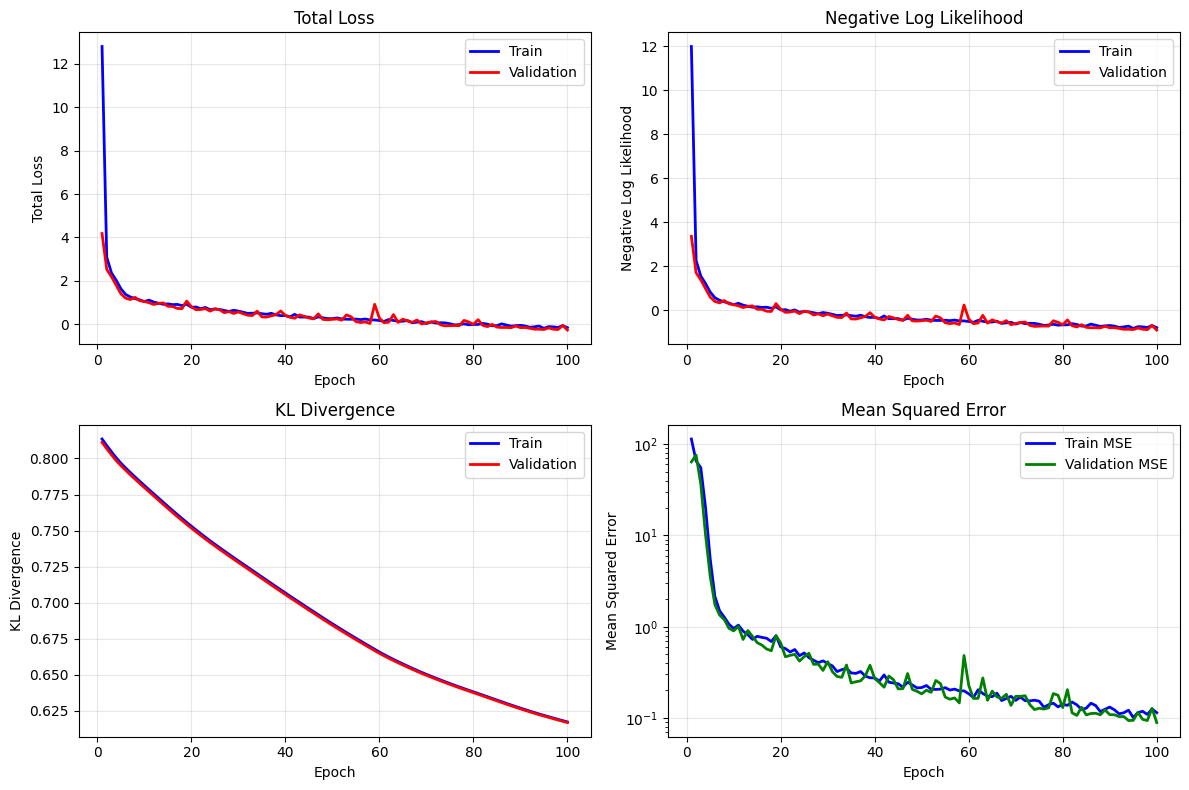

In [63]:
# Set up plotting style
plt.style.use('default')
fig_width = 12
fig_height = 8

# 1. Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(fig_width, fig_height))

epochs_range = range(1, len(train_losses) + 1)

# Total loss
axes[0, 0].plot(epochs_range, train_losses, 'b-', label='Train', linewidth=2)
axes[0, 0].plot(epochs_range, val_losses, 'r-', label='Validation', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Total Loss')
axes[0, 0].set_title('Total Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# NLL
axes[0, 1].plot(epochs_range, train_nlls, 'b-', label='Train', linewidth=2)
axes[0, 1].plot(epochs_range, val_nlls, 'r-', label='Validation', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Negative Log Likelihood')
axes[0, 1].set_title('Negative Log Likelihood')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# KL Divergence
axes[1, 0].plot(epochs_range, train_kls, 'b-', label='Train', linewidth=2)
axes[1, 0].plot(epochs_range, val_kls, 'r-', label='Validation', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('KL Divergence')
axes[1, 0].set_title('KL Divergence')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# MSE
axes[1, 1].plot(epochs_range, train_mses, 'b-', label='Train MSE', linewidth=2)
axes[1, 1].plot(epochs_range, val_mses, 'g-', label='Validation MSE', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Mean Squared Error')
axes[1, 1].set_yscale('log')
axes[1, 1].set_title('Mean Squared Error')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Solution 7: Uncertainty Quantification

In [ ]:
def get_prediction(model, dataloader, n_monte=30):
    """
    Monte Carlo sampling to get predictions and uncertainties
    """
    model.eval()

    # Collect all predictions
    all_targets = []
    all_means = []
    all_vars = []

    # Get targets (only need to do this once)
    with torch.no_grad():
        for X, y in dataloader:
            all_targets.append(y.cpu().numpy())

    targets = np.concatenate(all_targets, axis=0)

    # Collect Monte Carlo samples
    mc_means = []
    mc_vars = []

    for sample in range(n_monte):
        sample_means = []
        sample_vars = []

        with torch.no_grad():
            for X, y in dataloader:
                pred = model(X)
                means = pred[:, 0].cpu().numpy()
                log_vars = pred[:, 1].cpu().numpy()

                sample_means.append(means)
                sample_vars.append(np.exp(log_vars))  # Convert log variance to variance

        mc_means.append(np.concatenate(sample_means, axis=0))
        mc_vars.append(np.concatenate(sample_vars, axis=0))

    # Convert to numpy arrays
    mc_means = np.array(mc_means)  # Shape: [n_monte, n_samples]
    mc_vars = np.array(mc_vars)    # Shape: [n_monte, n_samples]

    # Calculate statistics
    pred_means = np.mean(mc_means, axis=0)  # Mean prediction across MC samples
    pred_systematic = np.var(mc_means, axis=0)  # systematic uncertainty (model uncertainty)
    pred_stochastic = np.mean(mc_vars, axis=0)  # Stochastic uncertainty (data uncertainty)
    pred_total = pred_systematic + pred_stochastic  # Total uncertainty

    return {
        'targets': targets.squeeze(),
        'predictions': pred_means,
        'systematic_uncertainty': pred_systematic,
        'stochastic_uncertainty': pred_stochastic,
        'total_uncertainty': pred_total,
        'mc_samples': mc_means
    }

# Get predictions with uncertainty
print("Computing predictions with uncertainty...")
test_results = get_prediction(model, tst_dataloader, n_monte=50)

print(f"Test set size: {len(test_results['targets'])}")
print(f"Mean absolute error: {np.mean(np.abs(test_results['predictions'] - test_results['targets'])):.4f}")
print(f"Mean systematic uncertainty: {np.mean(test_results['systematic_uncertainty']):.4f}")
print(f"Mean stochastic uncertainty: {np.mean(test_results['stochastic_uncertainty']):.4f}")
print(f"Mean total uncertainty: {np.mean(test_results['total_uncertainty']):.4f}")

Computing predictions with uncertainty...
Test set size: 30000
Mean absolute error: 0.1279
Mean epistemic uncertainty: 0.0555
Mean aleatoric uncertainty: 0.1036
Mean total uncertainty: 0.1591


## Solution 8: Analysis and Visualization

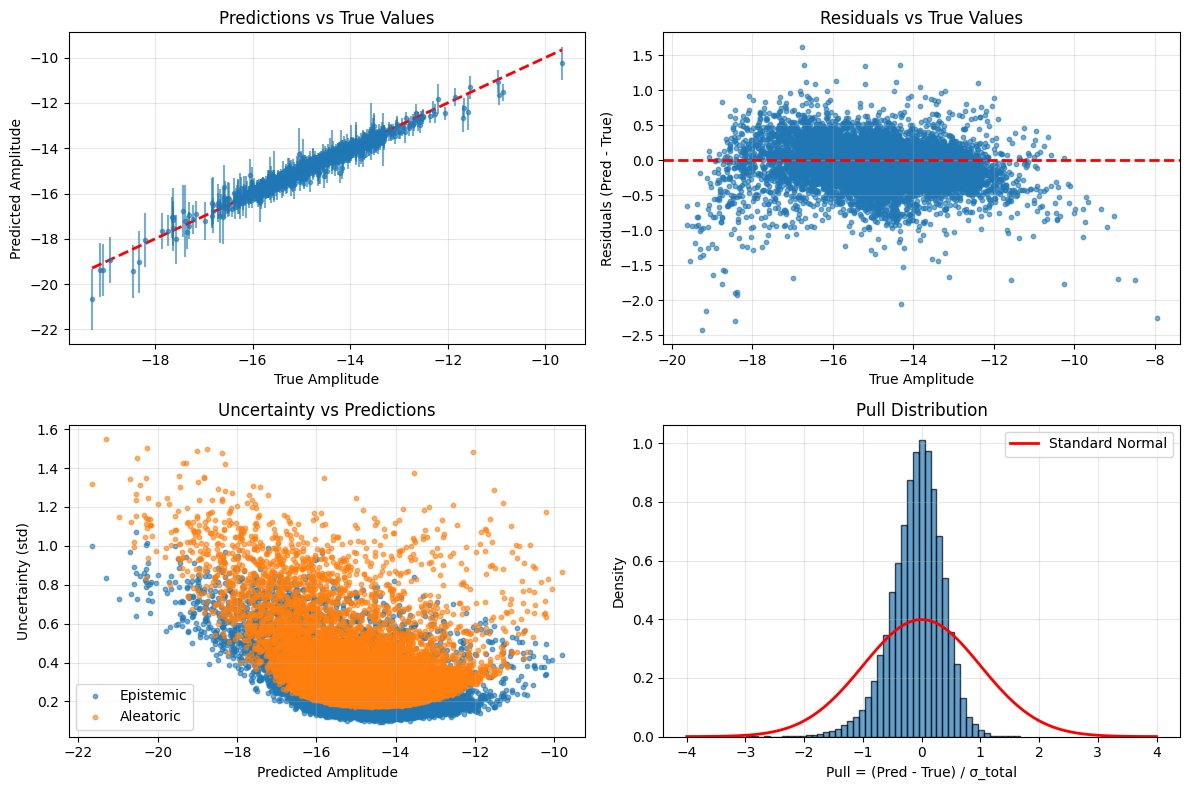


Pull Distribution Statistics:
Mean: -0.085 (should be ≈ 0)
Std: 0.440 (should be ≈ 1)
Skewness: -0.597
Kurtosis: 4.325


In [ ]:
# 2. Prediction vs True values
fig, axes = plt.subplots(2, 2, figsize=(fig_width, fig_height))

# Scatter plot with error bars
n_plot = min(1000, len(test_results['targets']))  # Plot subset for clarity
idx = np.random.choice(len(test_results['targets']), n_plot, replace=False)

targets_plot = test_results['targets'][idx]
preds_plot = test_results['predictions'][idx]
uncert_plot = np.sqrt(test_results['total_uncertainty'][idx])

# Predictions vs targets
axes[0, 0].errorbar(targets_plot, preds_plot, yerr=uncert_plot,
                   fmt='o', alpha=0.6, markersize=3, capsize=0)
axes[0, 0].plot([targets_plot.min(), targets_plot.max()],
               [targets_plot.min(), targets_plot.max()], 'r--', linewidth=2)
axes[0, 0].set_xlabel('True Amplitude')
axes[0, 0].set_ylabel('Predicted Amplitude')
axes[0, 0].set_title('Predictions vs True Values')
axes[0, 0].grid(True, alpha=0.3)

# Residuals
residuals = test_results['predictions'] - test_results['targets']
axes[0, 1].scatter(test_results['targets'], residuals, alpha=0.6, s=10)
axes[0, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('True Amplitude')
axes[0, 1].set_ylabel('Residuals (Pred - True)')
axes[0, 1].set_title('Residuals vs True Values')
axes[0, 1].grid(True, alpha=0.3)

# Uncertainty analysis
axes[1, 0].scatter(test_results['predictions'],
                  np.sqrt(test_results['systematic_uncertainty']),
                  alpha=0.6, s=10, label='Systematic')
axes[1, 0].scatter(test_results['predictions'],
                  np.sqrt(test_results['stochastic_uncertainty']),
                  alpha=0.6, s=10, label='Stochastic')
axes[1, 0].set_xlabel('Predicted Amplitude')
axes[1, 0].set_ylabel('Uncertainty (std)')
axes[1, 0].set_title('Uncertainty vs Predictions')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Pull distribution
pulls = residuals / np.sqrt(test_results['total_uncertainty'])
axes[1, 1].hist(pulls, bins=50, alpha=0.7, density=True, edgecolor='black')
x_norm = np.linspace(-4, 4, 100)
axes[1, 1].plot(x_norm, np.exp(-0.5 * x_norm**2) / np.sqrt(2 * np.pi),
               'r-', linewidth=2, label='Standard Normal')
axes[1, 1].set_xlabel('Pull = (Pred - True) / σ_total')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Pull Distribution')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print pull statistics
print(f"\nPull Distribution Statistics:")
print(f"Mean: {np.mean(pulls):.3f} (should be ≈ 0)")
print(f"Std: {np.std(pulls):.3f} (should be ≈ 1)")
print(f"Skewness: {((pulls - np.mean(pulls))**3).mean() / np.std(pulls)**3:.3f}")
print(f"Kurtosis: {((pulls - np.mean(pulls))**4).mean() / np.std(pulls)**4:.3f}")

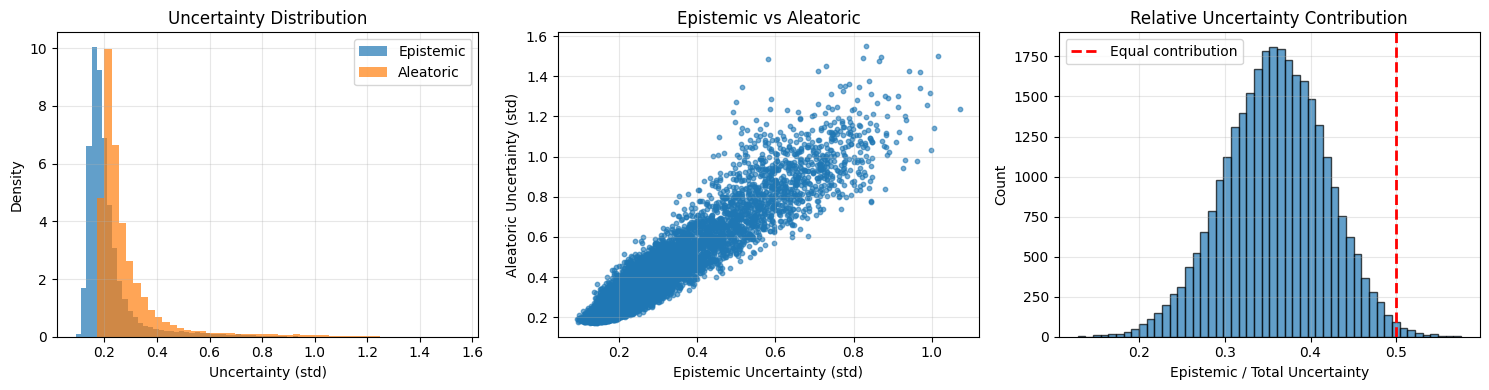


Uncertainty Analysis:
Average epistemic uncertainty: 0.2130
Average aleatoric uncertainty: 0.2878
Epistemic/Total ratio: 0.359 ± 0.059


In [ ]:
# 3. Uncertainty decomposition analysis
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram of uncertainties
axes[0].hist(np.sqrt(test_results['systematic_uncertainty']), bins=50, alpha=0.7,
            label='Systematic', density=True)
axes[0].hist(np.sqrt(test_results['stochastic_uncertainty']), bins=50, alpha=0.7,
            label='Stochastic', density=True)
axes[0].set_xlabel('Uncertainty (std)')
axes[0].set_ylabel('Density')
axes[0].set_title('Uncertainty Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# systematic vs Stochastic scatter
axes[1].scatter(np.sqrt(test_results['systematic_uncertainty']),
               np.sqrt(test_results['stochastic_uncertainty']),
               alpha=0.6, s=10)
axes[1].set_xlabel('Systematic Uncertainty (std)')
axes[1].set_ylabel('Stochastic Uncertainty (std)')
axes[1].set_title('Systematic vs Stochastic')
axes[1].grid(True, alpha=0.3)

# Relative contribution
systematic_fraction = test_results['systematic_uncertainty'] / test_results['total_uncertainty']
axes[2].hist(systematic_fraction, bins=50, alpha=0.7, edgecolor='black')
axes[2].axvline(x=0.5, color='r', linestyle='--', linewidth=2,
               label='Equal contribution')
axes[2].set_xlabel('Systematic / Total Uncertainty')
axes[2].set_ylabel('Count')
axes[2].set_title('Relative Uncertainty Contribution')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nUncertainty Analysis:")
print(f"Average systematic uncertainty: {np.sqrt(test_results['systematic_uncertainty']).mean():.4f}")
print(f"Average stochastic uncertainty: {np.sqrt(test_results['stochastic_uncertainty']).mean():.4f}")
print(f"Systematic/Total ratio: {systematic_fraction.mean():.3f} ± {systematic_fraction.std():.3f}")